In [44]:
import numpy as np
import h5py
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [39]:
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

from keras.models import Sequential, load_model

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPool2D
#from keras.optimizers import Adam,RMSprop
from keras.initializers import RandomNormal
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,RMSprop

**Notebook content**
* [Load data](#load)
* [Define the CNN (without Bayesian Optimization)](#cnn)
* [Define the CNN (Bayesian Optimization)](#cnn_bo)
* [Define the Hyperparameter Space ](#hyper)
* [Define the Objective Function](#obj)
* [Test run](#test)
* [Bayesian Optimization](#opt)
* [Results analysis](#result)
    * [Convergence](#con)
    * [Partially dependency plots](#plot1)
    * [Evaluation order](#plot2)
* [Evaluate the model](#eval)
* [Confusion matrix](#cm)

## Load data  <a class="anchor"  id="load"></a>

In [5]:
def load_dataset():
    train_data = h5py.File('data/train_happy.h5', "r")
    X_train = np.array(train_data["train_set_x"][:]) 
    y_train = np.array(train_data["train_set_y"][:]) 

    test_data = h5py.File('data/test_happy.h5', "r")
    X_test = np.array(test_data["test_set_x"][:])
    y_test = np.array(test_data["test_set_y"][:]) 
    
    y_train = y_train.reshape((1, y_train.shape[0]))
    y_test = y_test.reshape((1, y_test.shape[0]))
    
    return X_train, y_train, X_test, y_test

In [6]:
X_train_orig, y_train_orig, X_test_orig, y_test_orig = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
y_train = y_train_orig.T
y_test = y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


Image shape : (64, 64, 3)


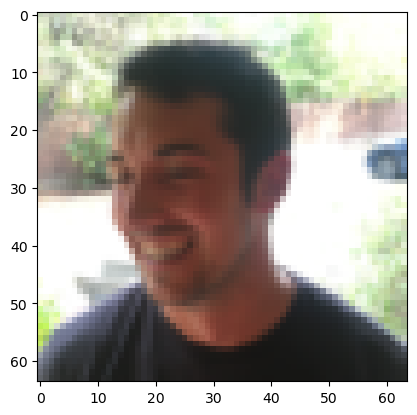

In [7]:
print("Image shape :",X_train_orig[77].shape)
imshow(X_train_orig[77][:,:,:])

## Define the CNN (without Bayesian Optimization) <a class="anchor"  id="cnn"></a>

In [13]:
model = Sequential()

model.add(Conv2D(filters=24, kernel_size=(3,3), activation='relu', padding='Same', input_shape=(64,64,3)))
model.add(Conv2D(filters=48, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 24)        672       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 48)        10416     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        27712     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [15]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
epochs = 15
batch_size = 30
history = model.fit(x=X_train, y=y_train, epochs=epochs, verbose=2, validation_data=(X_test, y_test), 
                    batch_size=batch_size)

Epoch 1/15
20/20 - 4s - loss: 0.6932 - accuracy: 0.4867 - val_loss: 0.6930 - val_accuracy: 0.5600
Epoch 2/15
20/20 - 1s - loss: 0.6932 - accuracy: 0.4867 - val_loss: 0.6931 - val_accuracy: 0.5600
Epoch 3/15
20/20 - 1s - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6931 - val_accuracy: 0.5600
Epoch 4/15
20/20 - 1s - loss: 0.6932 - accuracy: 0.4900 - val_loss: 0.6931 - val_accuracy: 0.5600
Epoch 5/15
20/20 - 1s - loss: 0.6932 - accuracy: 0.4533 - val_loss: 0.6931 - val_accuracy: 0.5600
Epoch 6/15
20/20 - 1s - loss: 0.6932 - accuracy: 0.4867 - val_loss: 0.6931 - val_accuracy: 0.5600
Epoch 7/15
20/20 - 1s - loss: 0.6932 - accuracy: 0.4633 - val_loss: 0.6931 - val_accuracy: 0.5600
Epoch 8/15
20/20 - 1s - loss: 0.6932 - accuracy: 0.4800 - val_loss: 0.6931 - val_accuracy: 0.5600
Epoch 9/15
20/20 - 1s - loss: 0.6932 - accuracy: 0.4900 - val_loss: 0.6931 - val_accuracy: 0.5600
Epoch 10/15
20/20 - 1s - loss: 0.6932 - accuracy: 0.4500 - val_loss: 0.6931 - val_accuracy: 0.5600
Epoch 11/15
20/20 -

### Define the CNN (Bayesian Optimization) <a class="anchor"  id="cnn_bo"></a>

In [16]:
def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
    kernel_size,
):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    kernel_size:       Kernel size.
    """
    
    model = Sequential()

    model.add(Conv2D(filters=24, kernel_size=(kernel_size, kernel_size), padding='same',
                     activation=activation, input_shape=(64,64,3), name='layer_conv1'))
    model.add(Conv2D(filters=48, kernel_size=(kernel_size, kernel_size), padding='same',
                     activation=activation, input_shape=(64,64,3), name='layer_conv2'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Conv2D(kernel_size=(3, 3), strides=1, filters=64, padding='same',
                     activation=activation, name='layer_conv3'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))
        model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

## Define the Hyperparameter Space <a class="anchor"  id="hyper"></a>

In [17]:
dim_learning_rate = Real(
    low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate',
)

dim_num_dense_layers = Integer(low=1, high=2, name='num_dense_layers')

dim_num_dense_nodes = Integer(low=5, high=128, name='num_dense_nodes')


dim_activation = Categorical(
    categories=['relu'], name='activation',
)

dim_kernel_size = Integer(low=3, high=9, name='kernel_size')

In [18]:
# the hyperparameter space grid

param_grid = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation,
              dim_kernel_size]

## Define the Objective Function <a class="anchor"  id="obj"></a>

In [19]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [20]:
@use_named_args(param_grid)
def objective(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
    kernel_size,
):
    
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    kernel_size:       Kernel size.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print('kernel_size:', kernel_size)
    print()
    
    # Create the neural network with the hyper-parameters.
    model = create_cnn(learning_rate=learning_rate,
                       num_dense_layers=num_dense_layers,
                       num_dense_nodes=num_dense_nodes,
                       activation=activation,
                       kernel_size=kernel_size)

   
    # this reduces the learning rate if learning does not improve
    # for a certain number of epochs
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.2, 
                                                min_lr=0.00001)
   
    # train the model
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=15,
                        batch_size=30,
                        validation_data=(X_test, y_test),
                        callbacks=learning_rate_reduction
                       )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    global best_accuracy

    if accuracy > best_accuracy:
        model.save(path_best_model)
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    
    # Scikit-optimize always minimizes the objective function
    return -accuracy

## Test run <a class="anchor"  id="test"></a>

In [22]:
default_parameters = [1e-5, 1, 10, 'relu', 3]
objective(x=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 10
activation: relu
kernel_size: 3

Epoch 1/15
20/20 [==============================] - 2s 64ms/step - loss: 0.9331 - accuracy: 0.5367 - val_loss: 0.6881 - val_accuracy: 0.4467
Epoch 2/15
20/20 [==============================] - 1s 50ms/step - loss: 0.6712 - accuracy: 0.6250 - val_loss: 0.6393 - val_accuracy: 0.5600
Epoch 3/15
20/20 [==============================] - 1s 47ms/step - loss: 0.5649 - accuracy: 0.7250 - val_loss: 0.4763 - val_accuracy: 0.7533
Epoch 4/15
20/20 [==============================] - 1s 47ms/step - loss: 0.5047 - accuracy: 0.7583 - val_loss: 0.3922 - val_accuracy: 0.8400
Epoch 5/15
20/20 [==============================] - 1s 47ms/step - loss: 0.3747 - accuracy: 0.8517 - val_loss: 0.3321 - val_accuracy: 0.8533
Epoch 6/15
20/20 [==============================] - 1s 47ms/step - loss: 0.2953 - accuracy: 0.8817 - val_loss: 0.3031 - val_accuracy: 0.8667
Epoch 7/15
20/20 [==============================] - 1s 47m

-0.9466666579246521

## Bayesian Optimization <a class="anchor"  id="opt"></a>

In [23]:
# gp_minimize performs by default GP Optimization 
# using a Marten Kernel

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    x0=default_parameters, # the initial parameters to test
    acq_func='EI', # the acquisition function
    n_calls=30, # the number of subsequent evaluations of f(x)
    random_state=0, 
)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 10
activation: relu
kernel_size: 3

Epoch 1/15
20/20 [==============================] - 2s 64ms/step - loss: 0.7135 - accuracy: 0.4917 - val_loss: 0.6932 - val_accuracy: 0.4400
Epoch 2/15
20/20 [==============================] - 1s 50ms/step - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6931 - val_accuracy: 0.5600
Epoch 3/15
20/20 [==============================] - 1s 46ms/step - loss: 0.6932 - accuracy: 0.4667 - val_loss: 0.6931 - val_accuracy: 0.5600
Epoch 4/15
20/20 [==============================] - 1s 46ms/step - loss: 0.6932 - accuracy: 0.4767 - val_loss: 0.6931 - val_accuracy: 0.5600

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/15
20/20 [==============================] - 1s 46ms/step - loss: 0.6932 - accuracy: 0.4867 - val_loss: 0.6931 - val_accuracy: 0.5600
Epoch 6/15
20/20 [==============================] - 1s 46ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931

Epoch 6/15
20/20 [==============================] - 1s 60ms/step - loss: 0.2569 - accuracy: 0.9017 - val_loss: 0.3477 - val_accuracy: 0.8400

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/15
20/20 [==============================] - 1s 61ms/step - loss: 0.1816 - accuracy: 0.9367 - val_loss: 0.1639 - val_accuracy: 0.9467
Epoch 8/15
20/20 [==============================] - 1s 61ms/step - loss: 0.1259 - accuracy: 0.9483 - val_loss: 0.1559 - val_accuracy: 0.9400
Epoch 9/15
20/20 [==============================] - 1s 60ms/step - loss: 0.1070 - accuracy: 0.9667 - val_loss: 0.1275 - val_accuracy: 0.9400

Epoch 00009: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 10/15
20/20 [==============================] - 1s 60ms/step - loss: 0.0979 - accuracy: 0.9650 - val_loss: 0.1270 - val_accuracy: 0.9533
Epoch 11/15
20/20 [==============================] - 1s 62ms/step - loss: 0.0872 - accuracy: 0.9667 - val_loss: 0.1247 - val_accur

20/20 [==============================] - 2s 77ms/step - loss: 0.0995 - accuracy: 0.9633 - val_loss: 0.1249 - val_accuracy: 0.9533

Epoch 00012: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 13/15
20/20 [==============================] - 2s 77ms/step - loss: 0.0673 - accuracy: 0.9733 - val_loss: 0.1245 - val_accuracy: 0.9600
Epoch 14/15
20/20 [==============================] - 2s 77ms/step - loss: 0.0610 - accuracy: 0.9800 - val_loss: 0.1219 - val_accuracy: 0.9600

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 15/15
20/20 [==============================] - 2s 78ms/step - loss: 0.0663 - accuracy: 0.9800 - val_loss: 0.1216 - val_accuracy: 0.9600

Accuracy: 96.00%

learning rate: 5.6e-06
num_dense_layers: 2
num_dense_nodes: 32
activation: relu
kernel_size: 5

Epoch 1/15
20/20 [==============================] - 3s 81ms/step - loss: 0.7163 - accuracy: 0.5100 - val_loss: 0.6869 - val_accuracy: 0.5600
Epoch 2/15
20/20 [=======================

Epoch 2/15
20/20 [==============================] - 1s 65ms/step - loss: 0.6237 - accuracy: 0.6733 - val_loss: 0.5522 - val_accuracy: 0.7533
Epoch 3/15
20/20 [==============================] - 1s 62ms/step - loss: 0.4201 - accuracy: 0.8050 - val_loss: 0.3845 - val_accuracy: 0.8133
Epoch 4/15
20/20 [==============================] - 1s 63ms/step - loss: 0.3733 - accuracy: 0.8383 - val_loss: 0.3794 - val_accuracy: 0.8267
Epoch 5/15
20/20 [==============================] - 1s 63ms/step - loss: 0.2200 - accuracy: 0.9217 - val_loss: 0.4847 - val_accuracy: 0.7667
Epoch 6/15
20/20 [==============================] - 1s 64ms/step - loss: 0.2862 - accuracy: 0.8900 - val_loss: 0.1760 - val_accuracy: 0.9333
Epoch 7/15
20/20 [==============================] - 1s 63ms/step - loss: 0.2872 - accuracy: 0.9000 - val_loss: 0.1795 - val_accuracy: 0.9467
Epoch 8/15
20/20 [==============================] - 1s 64ms/step - loss: 0.1405 - accuracy: 0.9450 - val_loss: 0.2088 - val_accuracy: 0.8933
Epoch 9/15
20

20/20 [==============================] - 1s 66ms/step - loss: 0.0955 - accuracy: 0.9667 - val_loss: 0.1435 - val_accuracy: 0.9600
Epoch 14/15
20/20 [==============================] - 1s 63ms/step - loss: 0.0973 - accuracy: 0.9700 - val_loss: 0.1505 - val_accuracy: 0.9400
Epoch 15/15
20/20 [==============================] - 1s 63ms/step - loss: 0.0839 - accuracy: 0.9717 - val_loss: 0.1341 - val_accuracy: 0.9533

Epoch 00015: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Accuracy: 95.33%

learning rate: 7.9e-06
num_dense_layers: 2
num_dense_nodes: 30
activation: relu
kernel_size: 3

Epoch 1/15
20/20 [==============================] - 3s 72ms/step - loss: 0.7699 - accuracy: 0.4850 - val_loss: 0.6862 - val_accuracy: 0.5600
Epoch 2/15
20/20 [==============================] - 1s 54ms/step - loss: 0.6943 - accuracy: 0.4717 - val_loss: 0.6762 - val_accuracy: 0.5600
Epoch 3/15
20/20 [==============================] - 1s 51ms/step - loss: 0.6867 - accuracy: 0.5550 - val_lo

20/20 [==============================] - 2s 95ms/step - loss: 0.2841 - accuracy: 0.8700 - val_loss: 0.2223 - val_accuracy: 0.8867
Epoch 9/15
20/20 [==============================] - 2s 96ms/step - loss: 0.2177 - accuracy: 0.9067 - val_loss: 0.2391 - val_accuracy: 0.8800
Epoch 10/15
20/20 [==============================] - 2s 97ms/step - loss: 0.4325 - accuracy: 0.8750 - val_loss: 0.5445 - val_accuracy: 0.8133

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 11/15
20/20 [==============================] - 2s 108ms/step - loss: 0.2081 - accuracy: 0.9183 - val_loss: 0.1519 - val_accuracy: 0.9533
Epoch 12/15
20/20 [==============================] - 2s 100ms/step - loss: 0.1287 - accuracy: 0.9583 - val_loss: 0.1423 - val_accuracy: 0.9600
Epoch 13/15
20/20 [==============================] - 2s 95ms/step - loss: 0.1178 - accuracy: 0.9667 - val_loss: 0.1330 - val_accuracy: 0.9400
Epoch 14/15
20/20 [==============================] - 2s 95ms/step - loss: 0.0

20/20 [==============================] - 2s 106ms/step - loss: 0.2238 - accuracy: 0.9100 - val_loss: 0.2087 - val_accuracy: 0.9200
Epoch 15/15
20/20 [==============================] - 2s 107ms/step - loss: 0.2308 - accuracy: 0.9050 - val_loss: 0.2037 - val_accuracy: 0.9267

Accuracy: 92.67%

learning rate: 1.4e-06
num_dense_layers: 1
num_dense_nodes: 66
activation: relu
kernel_size: 5

Epoch 1/15
20/20 [==============================] - 3s 82ms/step - loss: 0.8413 - accuracy: 0.5450 - val_loss: 0.6864 - val_accuracy: 0.4733
Epoch 2/15
20/20 [==============================] - 1s 64ms/step - loss: 0.6866 - accuracy: 0.5750 - val_loss: 0.6686 - val_accuracy: 0.6267
Epoch 3/15
20/20 [==============================] - 1s 61ms/step - loss: 0.7362 - accuracy: 0.7033 - val_loss: 0.5163 - val_accuracy: 0.7800
Epoch 4/15
20/20 [==============================] - 1s 61ms/step - loss: 0.5096 - accuracy: 0.7567 - val_loss: 0.5110 - val_accuracy: 0.7400
Epoch 5/15
20/20 [=============================

## Results analysis <a class="anchor"  id="result"></a>

In [72]:
print(f'Best score = {-gp_.fun:.4f}')

Best score = 0.9667


In [112]:
print(f'Best parameters:')
print('_'*10)
print(f' learning rate = {gp_.x[0]:.6f}\n num_dense_layers = {gp_.x[1]}\
     \n num_nodes = {gp_.x[2]} \n activation = {gp_.x[3]} \
     \n kernel_size= {gp_.x[4]}')

Best parameters:
__________
 learning rate = 0.000004
 num_dense_layers = 1     
 num_nodes = 53 
 activation = relu      
 kernel_size= 6


### Convergence <a class="anchor"  id="con"></a>

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

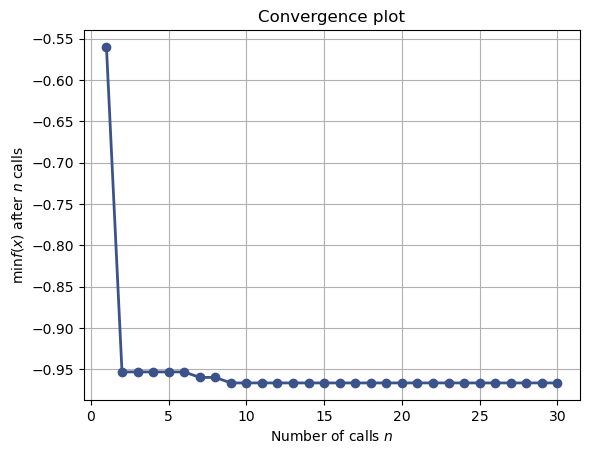

In [33]:
plot_convergence(gp_)

### Partially dependency plots <a class="anchor"  id="plot1"></a>
[plot_objective](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_objective.html#skopt.plots.plot_objective)

In [34]:
dim_names = ['learning_rate', 'num_dense_nodes', 'num_dense_layers', 'kernel_size']

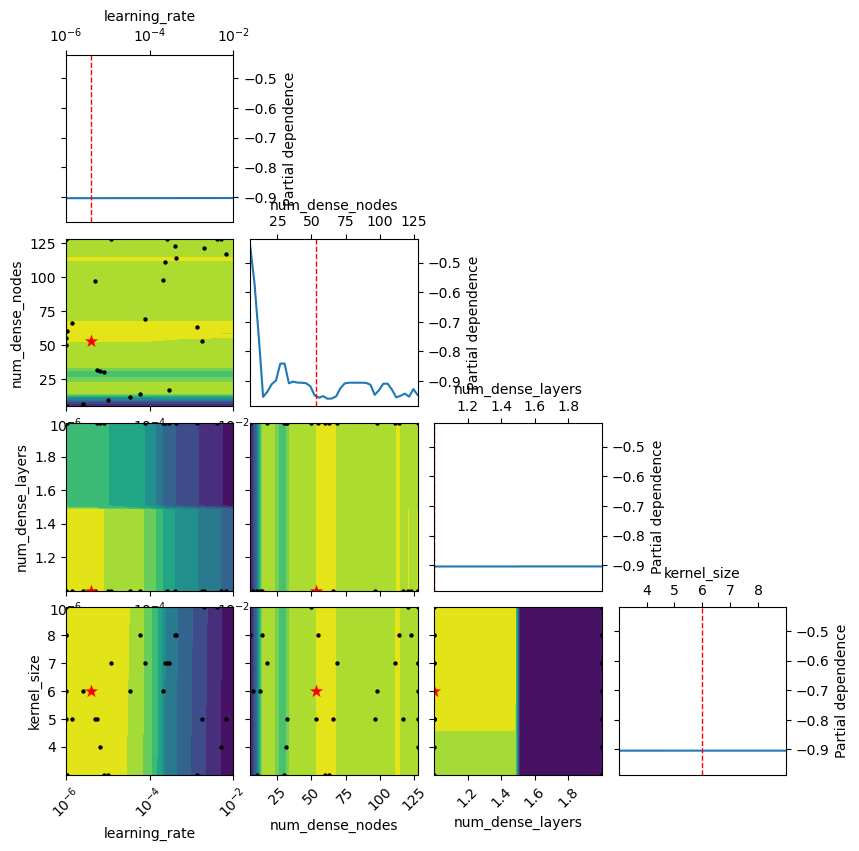

In [35]:
plot_objective(result=gp_, plot_dims=dim_names)
plt.show()

### Evaluation order <a class="anchor"  id="plot2"></a>
[plot_evaluations](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_evaluations.html)

In [66]:
dim_names[:-1]

['learning_rate', 'num_dense_nodes', 'num_dense_layers']

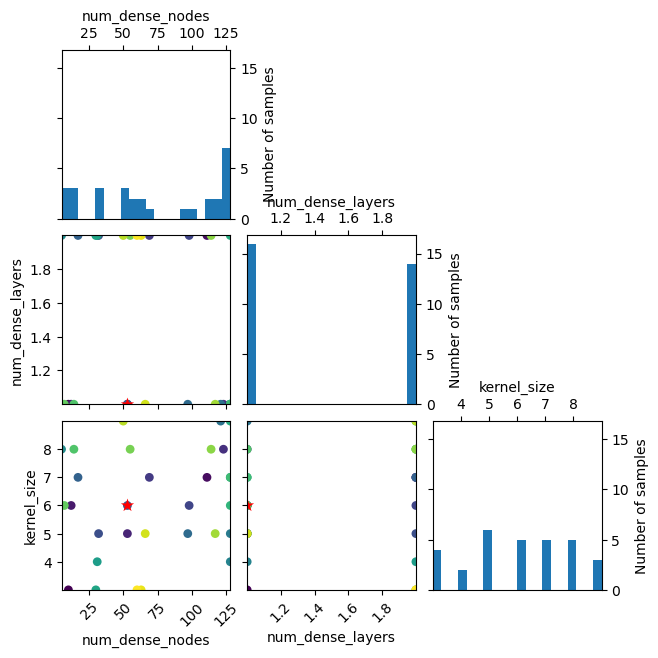

In [68]:
plot_evaluations(result=gp_, plot_dims=dim_names[1:])
plt.show()

## Evaluate the model<a class="anchor"  id="eval"></a>

In [40]:
# load best model
model = load_model(path_best_model)

In [41]:
# make predictions in test set

result = model.evaluate(x=X_test, y=y_test)

5/5 [==============================] - 1s 127ms/step - loss: 0.1031 - accuracy: 0.9667


In [42]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.10306840389966965
accuracy 0.9666666388511658


## Confusion matrix<a class="anchor"  id="cm"></a>

In [63]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = [1 * (x[0]>=0.5) for x in y_pred]

# compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes) 

cm

array([[64,  2],
       [ 3, 81]], dtype=int64)